# 전략 Backtest
### Portfolio
* KOSDAQ 시장에 국한하여 전날 종가에 매수하여 익일 시가에 매도한다.

In [92]:
import pandas as pd

In [93]:
kosdaq_train = pd.read_excel('./datas/kosdaq_closing_quotation_strategy.xlsx').fillna(value=0.0) 

In [94]:
print(kosdaq_train.shape)
print('Index => ', kosdaq_train.index)
print('Column => ', kosdaq_train.columns)
kosdaq_train.head()

(4480, 5)
Index =>  RangeIndex(start=0, stop=4480, step=1)
Column =>  Index(['date', 'open', 'high', 'low', 'close'], dtype='object')


,date,open,high,low,close
0,1999/12/24,2608.9,2619.6,2491.7,2566.3
1,1999/12/27,2558.1,2680.1,2525.5,2564.5
2,1999/12/28,2543.6,2594.4,2529.2,2561.4
3,2000/01/04,2583.8,2682.6,2528.5,2660.0
4,2000/01/05,2561.6,2635.8,2532.3,2629.5


In [95]:
# date type -> datetime으로 변환함.
kosdaq_train['date'] = pd.to_datetime(kosdaq_train['date'])
kosdaq_train.head()

,date,open,high,low,close
0,1999-12-24,2608.9,2619.6,2491.7,2566.3
1,1999-12-27,2558.1,2680.1,2525.5,2564.5
2,1999-12-28,2543.6,2594.4,2529.2,2561.4
3,2000-01-04,2583.8,2682.6,2528.5,2660.0
4,2000-01-05,2561.6,2635.8,2532.3,2629.5


### 코스닥 그래프

In [96]:
%matplotlib inline
# import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime as dt
import numpy as np

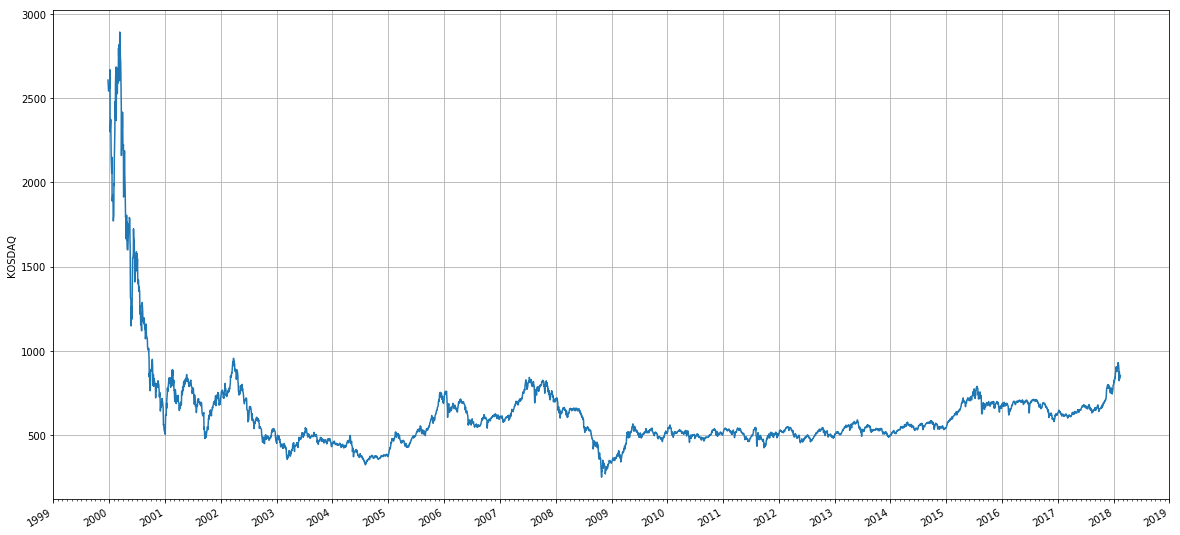

In [97]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(20, 10)
ax.plot(kosdaq_train.date, kosdaq_train.open)

# format the ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years...
datemin = np.datetime64(kosdaq_train.date[0], 'Y')
datemax = np.datetime64(kosdaq_train.iloc[-1].date, 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
figure.autofmt_xdate()

plt.ylabel('KOSDAQ')

plt.show()

In [98]:
# 거래비용
transaction_cost = 0.01

In [99]:
def close_open_earning(df, idx):
    df.loc[idx:idx+1, 'close-open'] = df.iloc[idx]['open'] / df.iloc[idx-1]['close'] - 1

def transaction_cost_earning(df, transaction_cost, idx):
    df.loc[idx:idx+1, 'tc_earning'] = df.iloc[idx]['open']*(1-transaction_cost) / df.iloc[idx-1]['close']*(1-transaction_cost) - 1
        
# 일별 증감 자산 추가
def daily_asset(df, idx):
    df.loc[idx:idx+1, 'asset'] = df.iloc[idx-1]['asset'] * (1 + df.iloc[idx]['close-open'])
        
def daily_transaction_cost_asset(df, idx):
    df.loc[idx:idx+1, 'tc_asset'] = df.iloc[idx-1]['tc_asset'] * (1 + df.iloc[idx]['tc_earning'])
    
def add_new_label(df, transaction_cost):
    for idx in range(1, len(df.index)):
        close_open_earning(df, idx)
        transaction_cost_earning(df, transaction_cost, idx)
        daily_asset(df, idx)
        daily_transaction_cost_asset(df, idx)

In [100]:
# 위 4가지 label 추가하기
kosdaq_train['close-open'] = 0.0
kosdaq_train['tc_earning'] = 0.0
kosdaq_train['asset'] = 1.0
kosdaq_train['tc_asset'] = 1.0
add_new_label(kosdaq_train, transaction_cost)

In [101]:
kosdaq_train.head()

,date,open,high,low,close,close-open,tc_earning,asset,tc_asset
0,1999-12-24,2608.9,2619.6,2491.7,2566.3,0.000000,0.000000,1.000000,1.000000
1,1999-12-27,2558.1,2680.1,2525.5,2564.5,-0.003195,-0.023032,0.996805,0.976968
2,1999-12-28,2543.6,2594.4,2529.2,2561.4,-0.008150,-0.027888,0.988681,0.949723
3,2000-01-04,2583.8,2682.6,2528.5,2660.0,0.008745,-0.011329,0.997327,0.938964
4,2000-01-05,2561.6,2635.8,2532.3,2629.5,-0.036992,-0.056156,0.960434,0.886235


In [102]:
kosdaq_train.tail()

,date,open,high,low,close,close-open,tc_earning,asset,tc_asset
4475,2018-02-07,874.75,875.03,829.96,829.96,0.019320,-0.000964,70866.834978,6.101473e-35
4476,2018-02-08,834.89,867.04,824.64,861.94,0.005940,-0.014078,71287.787188,6.015575e-35
4477,2018-02-09,832.13,850.70,832.13,842.60,-0.034585,-0.053797,68822.315188,5.691958e-35
4478,2018-02-12,854.09,854.94,843.24,843.24,0.013636,-0.006535,69760.801304,5.654761e-35
4479,2018-02-13,852.94,854.08,840.08,843.26,0.011503,-0.008626,70563.277198,5.605985e-35


### Asset 추이 Graph

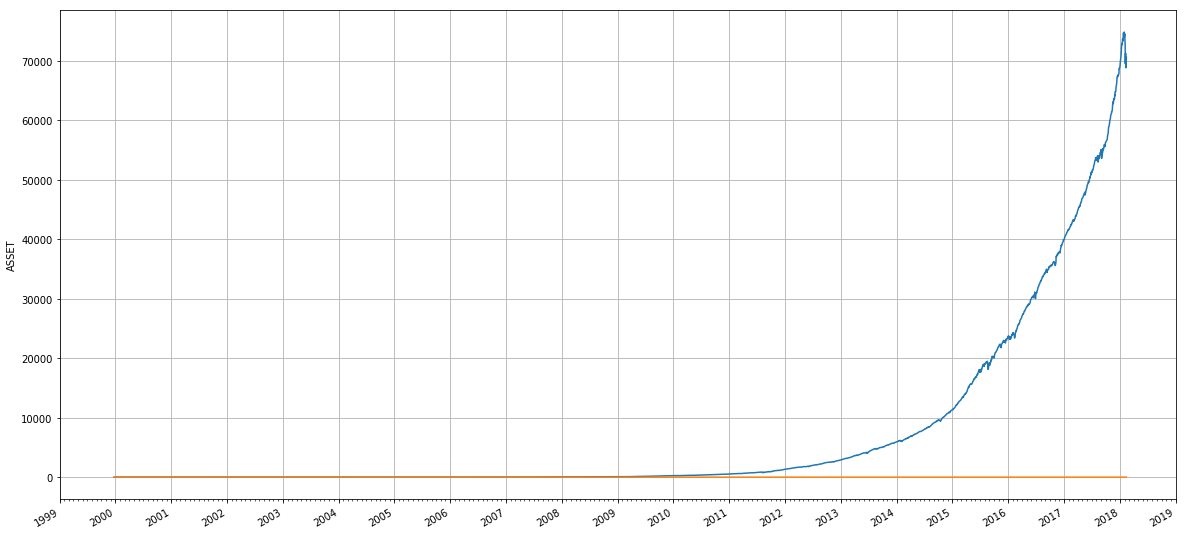

In [103]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(20, 10)
ax.plot(kosdaq_train.date, kosdaq_train.asset)
ax.plot(kosdaq_train.date, kosdaq_train.tc_asset)

# format the ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years...
datemin = np.datetime64(kosdaq_train.date[0], 'Y')
datemax = np.datetime64(kosdaq_train.iloc[-1].date, 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
figure.autofmt_xdate()

plt.ylabel('ASSET')

plt.show()

### DD, MDD 구하기

In [104]:
kosdaq_train['max_asset'] = kosdaq_train.loc[0,].asset

In [105]:
kosdaq_train.head()

,date,open,high,low,close,close-open,tc_earning,asset,tc_asset,max_asset
0,1999-12-24,2608.9,2619.6,2491.7,2566.3,0.000000,0.000000,1.000000,1.000000,1.0
1,1999-12-27,2558.1,2680.1,2525.5,2564.5,-0.003195,-0.023032,0.996805,0.976968,1.0
2,1999-12-28,2543.6,2594.4,2529.2,2561.4,-0.008150,-0.027888,0.988681,0.949723,1.0
3,2000-01-04,2583.8,2682.6,2528.5,2660.0,0.008745,-0.011329,0.997327,0.938964,1.0
4,2000-01-05,2561.6,2635.8,2532.3,2629.5,-0.036992,-0.056156,0.960434,0.886235,1.0


In [106]:
# MAX ASSET
def max_asset(df):
    df['max_asset'] = kosdaq_train.loc[0,].asset
    for idx in range(1, len(df.index)):
        df.loc[idx:idx+1, 'max_asset'] = max(df.iloc[idx-1]['asset'], df.iloc[idx]['max_asset'])

In [107]:
max_asset(kosdaq_train)

In [108]:
kosdaq_train.tail()

,date,open,high,low,close,close-open,tc_earning,asset,tc_asset,max_asset
4475,2018-02-07,874.75,875.03,829.96,829.96,0.019320,-0.000964,70866.834978,6.101473e-35,74838.783807
4476,2018-02-08,834.89,867.04,824.64,861.94,0.005940,-0.014078,71287.787188,6.015575e-35,74838.783807
4477,2018-02-09,832.13,850.70,832.13,842.60,-0.034585,-0.053797,68822.315188,5.691958e-35,74838.783807
4478,2018-02-12,854.09,854.94,843.24,843.24,0.013636,-0.006535,69760.801304,5.654761e-35,74838.783807
4479,2018-02-13,852.94,854.08,840.08,843.26,0.011503,-0.008626,70563.277198,5.605985e-35,74838.783807


In [109]:
# dd
kosdaq_train['dd'] = kosdaq_train.asset / kosdaq_train.max_asset - 1
kosdaq_train.loc[kosdaq_train["dd"] > 0.0, "dd"] = 0.0

In [111]:
kosdaq_train.head()

,date,open,high,low,close,close-open,tc_earning,asset,tc_asset,max_asset,dd
0,1999-12-24,2608.9,2619.6,2491.7,2566.3,0.000000,0.000000,1.000000,1.000000,1.0,0.000000
1,1999-12-27,2558.1,2680.1,2525.5,2564.5,-0.003195,-0.023032,0.996805,0.976968,1.0,-0.003195
2,1999-12-28,2543.6,2594.4,2529.2,2561.4,-0.008150,-0.027888,0.988681,0.949723,1.0,-0.011319
3,2000-01-04,2583.8,2682.6,2528.5,2660.0,0.008745,-0.011329,0.997327,0.938964,1.0,-0.002673
4,2000-01-05,2561.6,2635.8,2532.3,2629.5,-0.036992,-0.056156,0.960434,0.886235,1.0,-0.039566


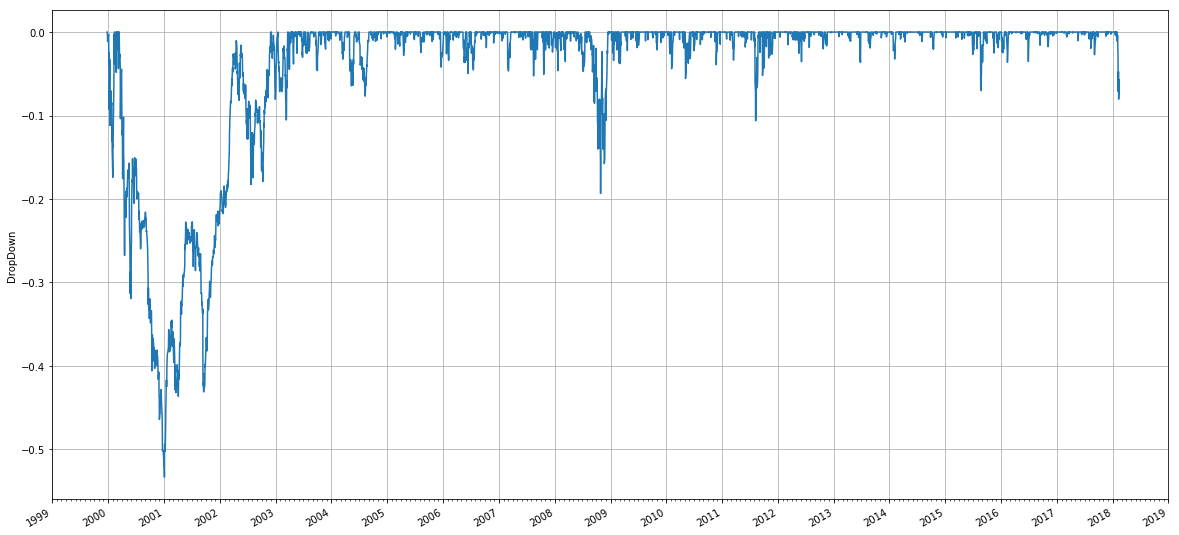

In [187]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(20, 10)
# ax.plot(kosdaq_train.date, kosdaq_train.asset)
# ax.plot(kosdaq_train.date, kosdaq_train.tc_asset)
ax.plot(kosdaq_train.date, kosdaq_train.dd)

# format the ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years...
datemin = np.datetime64(kosdaq_train.date[0], 'Y')
datemax = np.datetime64(kosdaq_train.iloc[-1].date, 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
figure.autofmt_xdate()

plt.ylabel('DropDown')

plt.show()

In [188]:
def CAGR(first, last, periods):
    return (last/first)**(1/periods)-1

In [189]:
period = kosdaq_train.iloc[-1].date.year - kosdaq_train.iloc[0].date.year
cagr = CAGR(kosdaq_train.iloc[0].asset, kosdaq_train.iloc[-1].asset, period)

print ('CAGR of {:.2%}'.format(cagr))
print('MDD of {:.2%}'.format(kosdaq_train.dd.min()))

CAGR of 79.97%
MDD of -53.33%
